# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Read the dataset
cleaned_df = pd.read_csv('/Users/priyakundu/Documents/NYU Capstone WaterVue Files/Data Processing/Updated_Dataframe_WaterQual.csv')
cleaned_df

,Location,Sample Date,Chlorophyll A,Dissolved Oxygen,Salinity,Specific Conductance,Total Nitrogen,Total Phosphorus,Turbidity
0,#1 HILLSBORO CANAL US 1,2006-02-28,12.100000,6.980000,19.400000,10.351373,0.830000,0.086000,2.400000
1,#1 HILLSBORO CANAL US 1,2006-08-31,4.430000,5.540000,15.750000,10.165844,0.981000,0.109000,1.400000
2,#1 HILLSBORO CANAL US 1,2007-02-28,2.605000,6.195000,23.200000,10.501905,0.754000,0.083500,1.650000
3,#1 HILLSBORO CANAL US 1,2007-08-31,4.890000,4.730000,31.100000,10.774781,0.777000,0.094000,2.300000
4,#1 HILLSBORO CANAL US 1,2008-02-29,5.925000,5.770000,12.500000,9.893361,1.440000,0.102000,2.050000
...,...,...,...,...,...,...,...,...,...
853,#89 NOB HILL RD POMPANO CANAL,2020-02-29,3.933333,5.703333,0.310000,6.451930,1.097133,0.014000,0.750000
854,#89 NOB HILL RD POMPANO CANAL,2020-08-31,1.570000,7.760000,0.250000,6.265301,0.910000,0.011000,0.000000
855,#89 NOB HILL RD POMPANO CANAL,2021-02-28,2.966667,5.833333,0.233333,6.153383,0.984033,0.003667,0.566667
856,#89 NOB HILL RD POMPANO CANAL,2021-08-31,5.510000,5.370000,0.270000,6.324359,1.410500,0.049000,0.775000


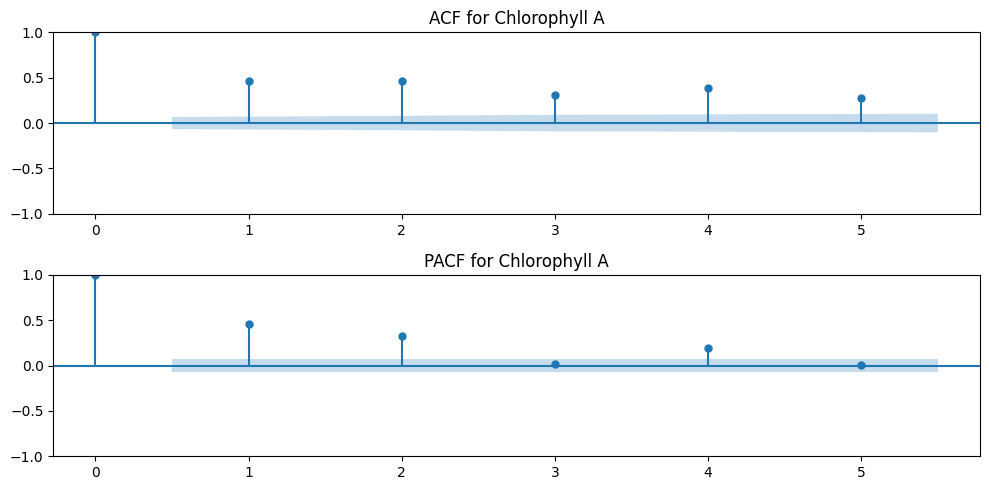

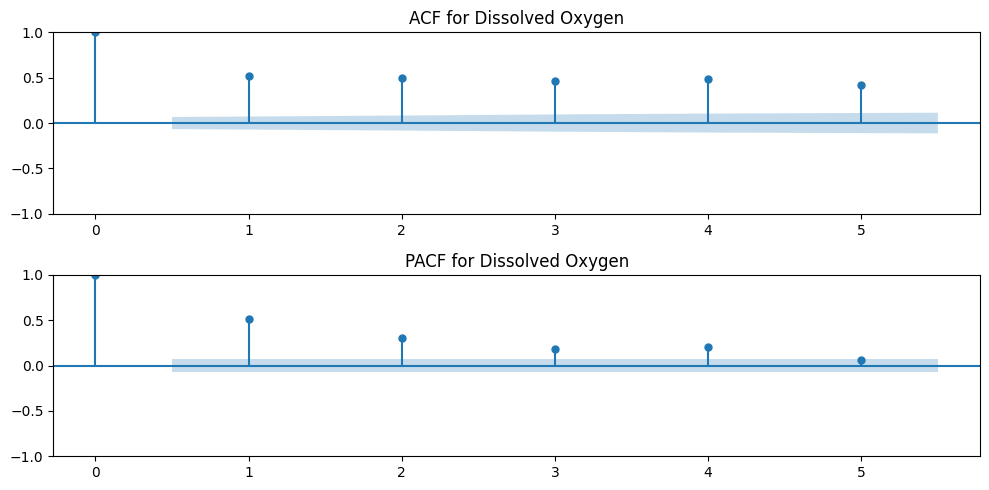

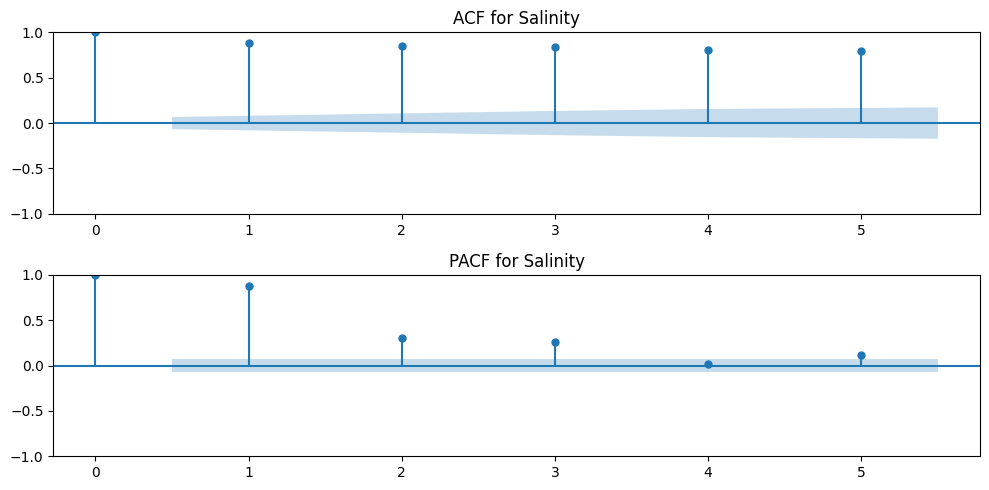

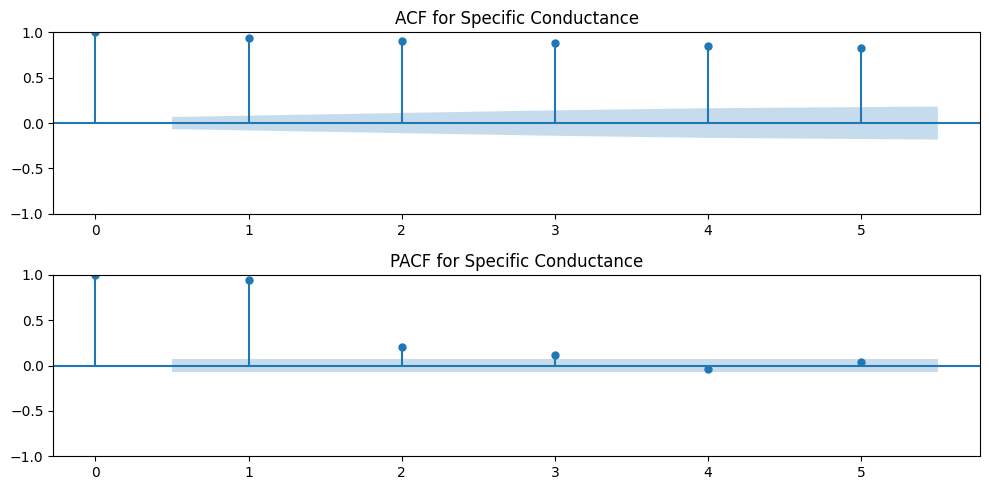

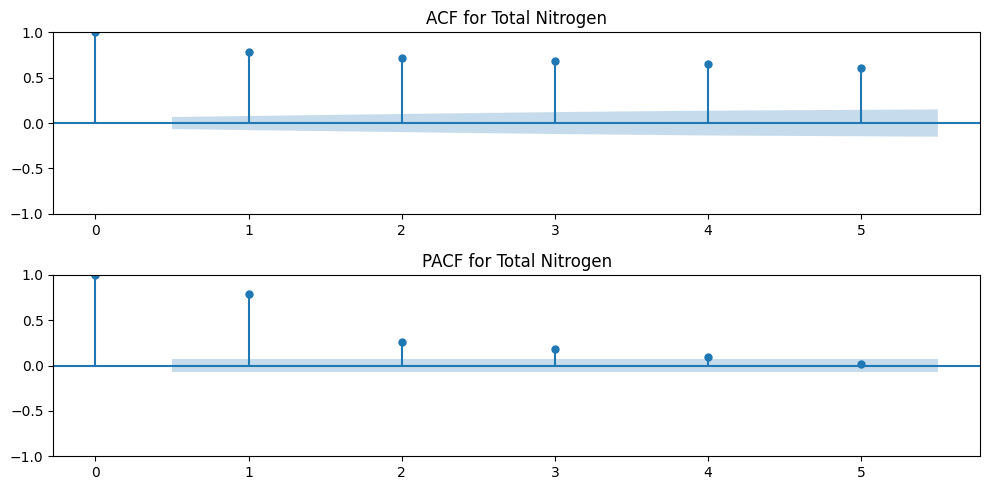

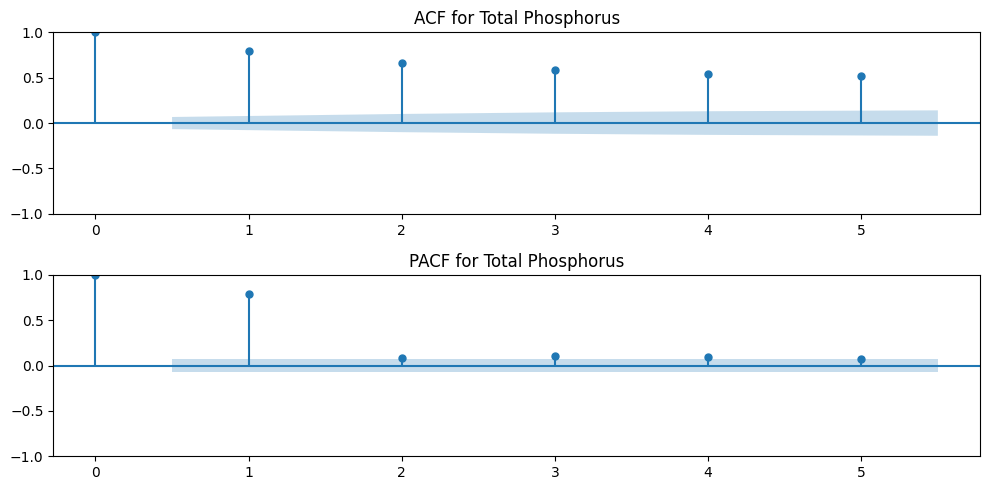

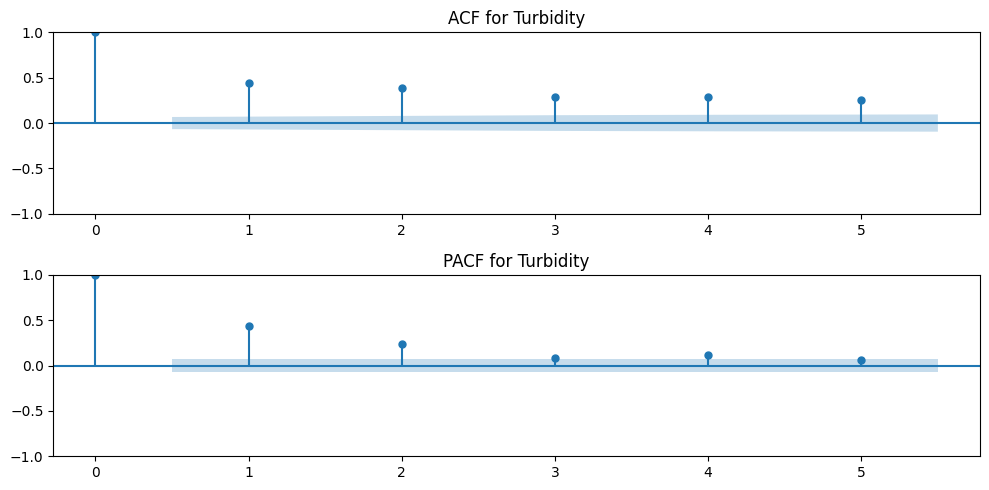

In [3]:
# Define the parameters list
parameters_list = ['Chlorophyll A', 'Dissolved Oxygen', 'Salinity', 
                   'Specific Conductance', 'Total Nitrogen', 'Total Phosphorus', 'Turbidity']

# Plot ACF and PACF for each parameter
for param in parameters_list:
    # Create a new figure for each parameter
    plt.figure(figsize=(10, 5))

    # Plot ACF
    plt.subplot(2, 1, 1)
    plot_acf(cleaned_df[param], lags=5, ax=plt.gca())
    plt.title(f'ACF for {param}')

    # Plot PACF
    plt.subplot(2, 1, 2)
    plot_pacf(cleaned_df[param], lags=5, ax=plt.gca())
    plt.title(f'PACF for {param}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Splitting

In [4]:
sorted_df = cleaned_df.sort_values(by='Sample Date', ascending=True)

In [5]:
# Split data into train and test sets
train_data = sorted_df.iloc[:-3*cleaned_df["Location"].nunique()].sort_values(by=['Location', 'Sample Date'], ascending=True)  # Use all but the last 12 months for training
test_data = sorted_df.iloc[-3*cleaned_df["Location"].nunique():].sort_values(by=['Location', 'Sample Date'], ascending=True)   # Use the last 12 months for testing

# Forecasting

In [6]:
attributes = ['Chlorophyll A', 'Dissolved Oxygen', 'Salinity', 'Specific Conductance', 'Total Nitrogen', 'Total Phosphorus', 'Turbidity']

In [7]:
final_dict = {}
hyper_params = [(1, 0, 2), (1, 1, 1), (1, 1, 2)]

for location in train_data["Location"].unique():
    att_rmse = {}
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    test_df = test_data[test_data["Location"] == location]

    for attribute in attributes:
        rmses = []
        for hyper in hyper_params:
            model = ARIMA(train_df[attribute], order=hyper)
            result = model.fit()

            # Forecast future values
            forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future

            mse = mean_squared_error(test_df[attribute], forecast)
            rmse = np.sqrt(mse)
            rmses.append(rmse)
        att_rmse[attribute] = rmses
    att_rmse_df = pd.DataFrame(att_rmse)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    att_rmse_df[attributes] = scaler.fit_transform(att_rmse_df[attributes].values)
    final_dict[location] = hyper_params[att_rmse_df.sum(axis=1).argmin()]

final_dict_df = pd.DataFrame({"Locations": final_dict.keys(), "Hyper Parameters": final_dict.values()})

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library

In [8]:
final_dict_df

,Locations,Hyper Parameters
0,#1 HILLSBORO CANAL US 1,"(1, 1, 1)"
1,#10 MIDDLE RIVER E SUNRISE,"(1, 1, 2)"
2,#110 POMPANO CANAL AT DIXIE AN,"(1, 0, 2)"
3,#111 S. FORK MID R. @ N.E. 15,"(1, 0, 2)"
4,#12 MIDDLE RIVER NW 31ST AVE,"(1, 1, 2)"
5,#15 NEW RIVER ANDREWS AVE,"(1, 1, 2)"
6,#17 PLANTATION CANAL @ S-33,"(1, 1, 2)"
7,#19 NEW RIVER RIVER REACH,"(1, 1, 1)"
8,#22 N NEW RIVER SW 125 AVE,"(1, 1, 1)"
9,#24 DANIA CUT-OFF US-1,"(1, 1, 1)"


In [9]:
att_rmse = {attribute: [] for attribute in attributes}

for location in final_dict:
	hyper = final_dict[location]
	train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
	train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
	test_df = test_data[test_data["Location"]==location]

	for attribute in attributes:
		model = ARIMA(train_df[attribute], order=hyper)
		result = model.fit()
		
		# Forecast future values
		forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future

		mse = mean_squared_error(test_df[attribute], forecast)
		rmse = np.sqrt(mse)
		att_rmse[attribute].append(rmse)

final_dict_df = pd.concat([final_dict_df, pd.DataFrame(att_rmse)], axis=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/Library

In [10]:
final_dict_df

,Locations,Hyper Parameters,Chlorophyll A,Dissolved Oxygen,Salinity,Specific Conductance,Total Nitrogen,Total Phosphorus,Turbidity
0,#1 HILLSBORO CANAL US 1,"(1, 1, 1)",1.532114,0.172349,3.885539,0.881166,0.146662,0.010844,0.421975
1,#10 MIDDLE RIVER E SUNRISE,"(1, 1, 2)",1.683662,0.223390,4.435719,0.209994,0.249810,0.043453,0.453916
2,#110 POMPANO CANAL AT DIXIE AN,"(1, 0, 2)",1.277055,0.738609,0.026320,0.109941,0.124745,0.017749,0.742085
3,#111 S. FORK MID R. @ N.E. 15,"(1, 0, 2)",3.345473,0.911607,6.828520,1.295071,0.219482,0.025641,0.226230
4,#12 MIDDLE RIVER NW 31ST AVE,"(1, 1, 2)",1.629179,1.268651,0.011599,0.065324,0.103704,0.006847,0.334790
5,#15 NEW RIVER ANDREWS AVE,"(1, 1, 2)",2.080099,0.894132,9.838708,0.971535,0.511806,0.039859,0.347467
6,#17 PLANTATION CANAL @ S-33,"(1, 1, 2)",2.255298,1.883363,0.034641,0.132625,0.276764,0.057491,0.304413
7,#19 NEW RIVER RIVER REACH,"(1, 1, 1)",2.421428,0.770735,4.456933,1.087646,0.274896,0.017690,0.376717
8,#22 N NEW RIVER SW 125 AVE,"(1, 1, 1)",0.915083,1.394191,0.018500,0.049906,0.119999,0.008784,0.324037
9,#24 DANIA CUT-OFF US-1,"(1, 1, 1)",0.781840,0.623530,10.509670,0.577211,0.224332,0.031674,0.174647


In [11]:
accuracy = 1 - (final_dict_df.iloc[:,2:]/final_dict_df.iloc[:,2:].max())

accuracy.insert(0,"Locations", final_dict_df["Locations"])
accuracy.insert(1,"Hyper Parameters", final_dict_df["Hyper Parameters"])


accuracy

,Locations,Hyper Parameters,Chlorophyll A,Dissolved Oxygen,Salinity,Specific Conductance,Total Nitrogen,Total Phosphorus,Turbidity
0,#1 HILLSBORO CANAL US 1,"(1, 1, 1)",0.615309,0.958278,0.630289,0.319600,0.713442,0.811384,0.541153
1,#10 MIDDLE RIVER E SUNRISE,"(1, 1, 2)",0.577258,0.945922,0.577939,0.837851,0.511905,0.244174,0.506421
2,#110 POMPANO CANAL AT DIXIE AN,"(1, 0, 2)",0.679351,0.821200,0.997496,0.915108,0.756264,0.691273,0.193071
3,#111 S. FORK MID R. @ N.E. 15,"(1, 0, 2)",0.160002,0.779321,0.350263,0.000000,0.571161,0.554009,0.754002
4,#12 MIDDLE RIVER NW 31ST AVE,"(1, 1, 2)",0.590938,0.692889,0.998896,0.949559,0.797375,0.880907,0.635956
5,#15 NEW RIVER ANDREWS AVE,"(1, 1, 2)",0.477718,0.783551,0.063842,0.249821,0.000000,0.306695,0.622171
6,#17 PLANTATION CANAL @ S-33,"(1, 1, 2)",0.433728,0.544081,0.996704,0.897592,0.459240,0.000000,0.668987
7,#19 NEW RIVER RIVER REACH,"(1, 1, 1)",0.392016,0.813423,0.575921,0.160165,0.462890,0.692295,0.590365
8,#22 N NEW RIVER SW 125 AVE,"(1, 1, 1)",0.770236,0.662498,0.998240,0.961465,0.765539,0.847217,0.647648
9,#24 DANIA CUT-OFF US-1,"(1, 1, 1)",0.803692,0.849058,0.000000,0.554302,0.561686,0.449060,0.810092


In [12]:
accuracy.describe()

,Chlorophyll A,Dissolved Oxygen,Salinity,Specific Conductance,Total Nitrogen,Total Phosphorus,Turbidity
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.525242,0.776387,0.729247,0.727230,0.657267,0.616950,0.531680
std,0.271684,0.204608,0.314500,0.296456,0.197104,0.258855,0.221429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.312854,0.742829,0.576425,0.599441,0.557714,0.466666,0.353183
50%,0.543816,0.799561,0.790146,0.852790,0.718373,0.681914,0.594618
75%,0.722278,0.890756,0.996098,0.930670,0.802154,0.841647,0.705799
max,0.980262,0.984399,0.999275,0.973445,0.894864,0.910813,0.828449


In [16]:
# Initialize a dictionary to store the Dissolved Oxygen range, mean, and mean error of prediction for each location
dissolved_oxygen_stats = {}

for location in final_dict_df["Locations"]:
    test_df_location = test_data[test_data["Location"] == location]
    dissolved_oxygen_range = round(test_df_location["Dissolved Oxygen"].min(), 3), round(test_df_location["Dissolved Oxygen"].max(), 3)
    dissolved_oxygen_mean = test_df_location["Dissolved Oxygen"].mean()
    
    # Grouping into categories
    category = None
    if dissolved_oxygen_mean >= 5.0:
        category = "Optimal"
    elif 2.1 <= dissolved_oxygen_mean <= 5.0:
        category = "Biological Stress"
    elif 0.6 <= dissolved_oxygen_mean <= 2.0:
        category = "Hypoxic"
    elif 0.0 <= dissolved_oxygen_mean <= 0.5:
        category = "Anoxic"
    
    mean_error_prediction = att_rmse["Dissolved Oxygen"][final_dict_df[final_dict_df["Locations"] == location].index[0]]
    
    dissolved_oxygen_stats[location] = {
        "Dissolved Oxygen Range": dissolved_oxygen_range,
        "Mean Dissolved Oxygen": dissolved_oxygen_mean,
        "Category": category,
        "Mean Error of Prediction": mean_error_prediction
    }

# Convert the dictionary to a DataFrame for easier visualization
dissolved_oxygen_stats_df = pd.DataFrame.from_dict(dissolved_oxygen_stats, orient='index')

In [17]:
dissolved_oxygen_stats_df

,Dissolved Oxygen Range,Mean Dissolved Oxygen,Category,Mean Error of Prediction
#1 HILLSBORO CANAL US 1,"(4.66, 4.95)",4.853333,Biological Stress,0.172349
#10 MIDDLE RIVER E SUNRISE,"(5.247, 5.35)",5.281111,Optimal,0.223390
#110 POMPANO CANAL AT DIXIE AN,"(3.66, 5.0)",4.508889,Biological Stress,0.738609
#111 S. FORK MID R. @ N.E. 15,"(4.15, 5.645)",4.691667,Biological Stress,0.911607
#12 MIDDLE RIVER NW 31ST AVE,"(4.535, 6.345)",5.353333,Optimal,1.268651
#15 NEW RIVER ANDREWS AVE,"(3.847, 5.84)",5.118889,Optimal,0.894132
#17 PLANTATION CANAL @ S-33,"(3.7, 4.53)",3.976667,Biological Stress,1.883363
#19 NEW RIVER RIVER REACH,"(3.173, 4.42)",3.904444,Biological Stress,0.770735
#22 N NEW RIVER SW 125 AVE,"(0.9, 3.62)",2.636667,Biological Stress,1.394191
#24 DANIA CUT-OFF US-1,"(3.69, 4.895)",4.231667,Biological Stress,0.623530
